# DS5230 Final Project – Association Rule Mining on Instacart

This notebook implements **Apriori** and **Eclat** on a curated Instacart basket dataset.
It expects two files in the same folder:
- `transactions_internal.csv` (one column `items`, each row like `24852,13176,47209`)
- `instacart_data/products.csv` (original Instacart file with `product_id`, `product_name`)

The notebook will:
- Load and clean transactions
- Run Apriori and Eclat with the same settings
- Generate association rules and basic sanity checks
- Create a set of plots and save them as PNG and a combined PDF
- Run a small minsup sensitivity study for both algorithms


In [1]:
import os
import time
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams["figure.dpi"] = 120

TRANSACTIONS_CSV = "transactions_internal.csv"
PRODUCTS_CSV = os.path.join("instacart_data", "products.csv")

MINSUP_ABS_MAIN = 20   # minimum support (absolute count)
MINCONF = 0.25         # minimum confidence
MAX_ITEMSET_LEN = 3

MINSUP_GRID = [20, 30, 40]
APRIORI_SENS_ENABLED = True  # can set False if it runs too long

FIG_ITEM_SUPPORT_TOP20   = "fig_item_support_top20.png"
FIG_RULE_SUPPORT_HIST_AP = "fig_rule_support_hist_apriori.png"
FIG_RULE_SCATTER_AP      = "fig_rule_support_confidence_scatter_apriori.png"
FIG_RULE_LIFT_TOP_AP     = "fig_rule_top20_lift_apriori.png"

FIG_RULE_SUPPORT_HIST_EC = "fig_rule_support_hist_eclat.png"
FIG_RULE_SCATTER_EC      = "fig_rule_support_confidence_scatter_eclat.png"
FIG_RULE_LIFT_TOP_EC     = "fig_rule_top20_lift_eclat.png"

FIG_RUNTIME_MINSUP_BOTH  = "fig_runtime_vs_minsup_apriori_eclat.png"
OUT_PDF                  = "association_rules_plots.pdf"

OUT_FREQ_APRIORI   = "frequent_itemsets_apriori.csv"
OUT_RULES_APRIORI  = "rules_apriori.csv"
OUT_FREQ_ECLAT     = "frequent_itemsets_eclat.csv"
OUT_RULES_ECLAT    = "rules_eclat.csv"
OUT_RULES_SUMMARY  = "rules_summary.csv"
OUT_APRIORI_SENS   = "apriori_minsup_sensitivity.csv"
OUT_ECLAT_SENS     = "eclat_minsup_sensitivity.csv"
OUT_TOP_RULES_PPT  = "top_rules_for_ppt.csv"


## 1. Load and inspect transactions
Here we parse `transactions_internal.csv` into a Python list of baskets.

In [2]:
def load_transactions(csv_path=TRANSACTIONS_CSV):
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"{csv_path} not found in current directory.")

    df = pd.read_csv(csv_path)
    if "items" not in df.columns:
        raise ValueError(f"{csv_path} must have a column named 'items'.")

    transactions = []
    for s in df["items"].dropna():
        if isinstance(s, str):
            parts = [p.strip() for p in s.split(",") if p.strip() != ""]
        else:
            parts = [str(int(s))]
        ids = set()
        for p in parts:
            try:
                ids.add(int(p))
            except ValueError:
                continue
        if ids:
            transactions.append(frozenset(ids))

    if not transactions:
        raise ValueError("No valid transactions parsed from items column.")

    N = len(transactions)
    item_ids = sorted({i for t in transactions for i in t})

    print(f"[LOAD] Loaded {N} transactions.")
    print(f"[LOAD] Unique item IDs: {len(item_ids)}")
    return transactions, N, item_ids


def load_product_id_to_name(products_csv=PRODUCTS_CSV, used_item_ids=None):
    if not os.path.isfile(products_csv):
        print(f"[LOAD] WARNING: {products_csv} not found. Using fallback names.")
        return {}

    df = pd.read_csv(products_csv)
    if "product_id" not in df.columns or "product_name" not in df.columns:
        raise ValueError("products.csv must have columns: product_id, product_name")

    df = df[["product_id", "product_name"]]
    if used_item_ids is not None:
        used_item_ids = set(int(i) for i in used_item_ids)
        df = df[df["product_id"].isin(used_item_ids)]

    id2name = dict(zip(df["product_id"].astype(int), df["product_name"].astype(str)))
    print(f"[LOAD] Loaded {len(id2name)} product_id → product_name mappings.")
    return id2name


transactions, N, item_ids = load_transactions()
id2name = load_product_id_to_name(used_item_ids=item_ids)

transactions[:5], list(id2name.items())[:5]

[LOAD] Loaded 9144 transactions.
[LOAD] Unique item IDs: 891
[LOAD] Loaded 890 product_id → product_name mappings.


([frozenset({667}),
  frozenset({101, 887}),
  frozenset({29, 56, 193, 439, 501}),
  frozenset({421, 807}),
  frozenset({638, 691})],
 [(1, 'Chocolate Sandwich Cookies'),
  (2, 'All-Seasons Salt'),
  (3, 'Robust Golden Unsweetened Oolong Tea'),
  (4, 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce'),
  (5, 'Green Chile Anytime Sauce')])

In [3]:
def apriori(transactions, minsup_abs, max_len):
    print(f"[APRIORI] minsup_abs={minsup_abs}, max_len={max_len}")
    support_counts = {}

    # L1
    item_counts = defaultdict(int)
    for t in transactions:
        for item in t:
            item_counts[item] += 1

    Lk = {frozenset([i]): c for i, c in item_counts.items() if c >= minsup_abs}
    support_counts.update(Lk)
    print(f"[APRIORI] |L1| = {len(Lk)}")

    k = 2
    while Lk and k <= max_len:
        prev_itemsets = list(Lk.keys())
        candidates = set()

        # join + prune
        for i in range(len(prev_itemsets)):
            for j in range(i + 1, len(prev_itemsets)):
                union = prev_itemsets[i] | prev_itemsets[j]
                if len(union) != k:
                    continue
                all_subfreq = True
                for subset in itertools.combinations(union, k - 1):
                    if frozenset(subset) not in Lk:
                        all_subfreq = False
                        break
                if all_subfreq:
                    candidates.add(union)

        Ck_counts = defaultdict(int)
        for t in transactions:
            for cand in candidates:
                if cand.issubset(t):
                    Ck_counts[cand] += 1

        Lk = {iset: cnt for iset, cnt in Ck_counts.items() if cnt >= minsup_abs}
        support_counts.update(Lk)
        print(f"[APRIORI] |L{k}| = {len(Lk)}")
        k += 1

    print(f"[APRIORI] total frequent itemsets = {len(support_counts)}")
    return support_counts

In [4]:
def eclat(transactions, minsup_abs, max_len):
    print(f"[ECLAT] minsup_abs={minsup_abs}, max_len={max_len}")
    item_tidsets = defaultdict(set)
    for tid, t in enumerate(transactions):
        for item in t:
            item_tidsets[item].add(tid)

    support_counts = {}
    initial_pairs = []
    for item, tids in item_tidsets.items():
        if len(tids) >= minsup_abs:
            iset = frozenset([item])
            support_counts[iset] = len(tids)
            initial_pairs.append((iset, tids))

    print(f"[ECLAT] |L1| = {len(initial_pairs)}")

    def recurse(prefix, tidset, pairs):
        for i in range(len(pairs)):
            itemset_i, tidset_i = pairs[i]
            if prefix:
                new_itemset = prefix | itemset_i
                new_tidset = tidset & tidset_i
            else:
                new_itemset = itemset_i
                new_tidset = tidset_i

            if len(new_itemset) > max_len:
                continue

            sup = len(new_tidset)
            if sup >= minsup_abs:
                support_counts[new_itemset] = sup

                new_pairs = []
                for j in range(i + 1, len(pairs)):
                    itemset_j, tidset_j = pairs[j]
                    inter = new_tidset & tidset_j
                    if len(inter) >= minsup_abs:
                        new_pairs.append((itemset_j, inter))
                if new_pairs:
                    recurse(new_itemset, new_tidset, new_pairs)

    recurse(frozenset(), set(), initial_pairs)
    print(f"[ECLAT] total frequent itemsets = {len(support_counts)}")
    return support_counts

In [5]:
def generate_rules_from_freq_itemsets(support_counts, N, minconf):
    rows = []
    for itemset, sup_cnt in support_counts.items():
        if len(itemset) < 2:
            continue
        itemset_len = len(itemset)
        support_itemset = sup_cnt / N

        for r in range(1, itemset_len):
            for antecedent_tuple in itertools.combinations(itemset, r):
                antecedent = frozenset(antecedent_tuple)
                consequent = itemset - antecedent
                if not consequent:
                    continue

                sup_A_cnt = support_counts.get(antecedent, 0)
                sup_B_cnt = support_counts.get(consequent, 0)
                if sup_A_cnt == 0 or sup_B_cnt == 0:
                    continue

                sup_A = sup_A_cnt / N
                sup_B = sup_B_cnt / N
                confidence = support_itemset / sup_A
                if confidence < minconf:
                    continue

                lift = confidence / sup_B

                rows.append({
                    "antecedent": tuple(sorted(antecedent)),
                    "consequent": tuple(sorted(consequent)),
                    "support": support_itemset,
                    "confidence": confidence,
                    "lift": lift,
                    "support_count": sup_cnt,
                    "antecedent_len": len(antecedent),
                    "consequent_len": len(consequent),
                    "itemset_len": itemset_len,
                })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(by=["lift", "confidence", "support"],
                            ascending=[False, False, False])
    return df


def sanity_check_rules(transactions, rules_df, n_check=3):
    if rules_df.empty:
        print("[CHECK] no rules to check")
        return

    N = len(transactions)
    n_check = min(n_check, len(rules_df))
    print(f"[CHECK] checking {n_check} rules")

    for i in range(n_check):
        row = rules_df.iloc[i]
        A = set(row["antecedent"])
        B = set(row["consequent"])
        AB = A | B

        count_AB = 0
        count_A = 0
        for t in transactions:
            if A.issubset(t):
                count_A += 1
                if AB.issubset(t):
                    count_AB += 1

        sup_emp = count_AB / N
        conf_emp = count_AB / count_A if count_A > 0 else 0.0

        delta_sup = abs(sup_emp - row["support"])
        delta_conf = abs(conf_emp - row["confidence"])
        print(f"  rule {i}: Δsupport={delta_sup:.2e}, Δconfidence={delta_conf:.2e}")


def itemset_dict_to_df(support_counts, N, id2name):
    rows = []
    for itemset, cnt in support_counts.items():
        ids = sorted(itemset)
        names = []
        for pid in ids:
            name = id2name.get(pid, None)
            if not name or pd.isna(name):
                name = f"item_{pid}"
            names.append(name)
        rows.append({
            "itemset_ids": ids,
            "itemset_names": names,
            "length": len(ids),
            "support_count": cnt,
            "support": cnt / N,
        })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(by=["length", "support"], ascending=[True, False])
    return df


def add_names_to_rules_df(rules_df, id2name):
    if rules_df.empty:
        return rules_df.copy()

    def ids_to_names(id_list):
        names = []
        for pid in id_list:
            name = id2name.get(pid, None)
            if not name or pd.isna(name):
                name = f"item_{pid}"
            names.append(name)
        return names

    df = rules_df.copy()
    df["antecedent_names"] = df["antecedent"].apply(ids_to_names)
    df["consequent_names"] = df["consequent"].apply(ids_to_names)
    return df


def select_top_lift_rules_for_plot(rules_df, top_k=20):
    if rules_df.empty:
        return rules_df.copy()

    pref = rules_df[
        (rules_df["antecedent_len"] <= 2) &
        (rules_df["consequent_len"] == 1)
    ].copy()

    if pref.empty:
        pref = rules_df.copy()

    pref = pref.sort_values(by=["lift", "confidence", "support"],
                            ascending=[False, False, False])
    return pref.head(top_k)

In [6]:
def plot_top_item_support(freq_itemsets_df, top_k=20, filename=FIG_ITEM_SUPPORT_TOP20):
    if freq_itemsets_df.empty:
        print("[FIG] no frequent itemsets for top item support")
        return

    df1 = freq_itemsets_df[freq_itemsets_df["length"] == 1].copy()
    if df1.empty:
        print("[FIG] no length-1 itemsets")
        return

    df1 = df1.sort_values(by="support", ascending=False).head(top_k)

    labels = [names[0] for names in df1["itemset_names"]]
    supports = df1["support"].values

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(labels)), supports)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Support")
    plt.title(f"Top-{top_k} Items by Support")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"[FIG] saved {filename}")


def plot_rule_support_hist(rules_df, algo_name, filename):
    if rules_df.empty:
        print(f"[FIG] no rules for support hist ({algo_name})")
        return

    plt.figure(figsize=(6, 4))
    plt.hist(rules_df["support"], bins=20)
    plt.xlabel("Support")
    plt.ylabel("Count")
    plt.title(f"Rule Support Distribution ({algo_name})")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"[FIG] saved {filename}")


def plot_rule_support_confidence_scatter(rules_df, algo_name, filename):
    if rules_df.empty:
        print(f"[FIG] no rules for scatter ({algo_name})")
        return

    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        rules_df["support"],
        rules_df["confidence"],
        c=rules_df["lift"],
        s=20,
        alpha=0.7,
    )
    plt.colorbar(sc, label="Lift")
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title(f"Support vs Confidence ({algo_name})")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"[FIG] saved {filename}")


def plot_top_lift_rules(rules_df, algo_name, filename, top_k=20):
    if rules_df.empty:
        print(f"[FIG] no rules for top-lift plot ({algo_name})")
        return

    top = select_top_lift_rules_for_plot(rules_df, top_k=top_k)

    labels = []
    for _, row in top.iterrows():
        a = ", ".join(row["antecedent_names"])
        b = ", ".join(row["consequent_names"])
        labels.append(f"{{{a}}} → {{{b}}}")

    lifts = top["lift"].values

    fig_height = max(4, 0.5 * len(labels))
    fig, ax = plt.subplots(figsize=(12, fig_height))
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, lifts)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_xlabel("Lift")
    ax.set_title(f"Top-{top_k} Rules by Lift ({algo_name})")
    ax.invert_yaxis()

    plt.subplots_adjust(left=0.45, right=0.98, top=0.95, bottom=0.05)
    plt.savefig(filename)
    plt.show()
    plt.close(fig)
    print(f"[FIG] saved {filename}")


def plot_runtime_vs_minsup_both(eclat_df, apriori_df, filename=FIG_RUNTIME_MINSUP_BOTH):
    if (eclat_df is None or eclat_df.empty) and (apriori_df is None or apriori_df.empty):
        print("[FIG] no sensitivity data for runtime plot")
        return

    plt.figure(figsize=(6, 4))
    if eclat_df is not None and not eclat_df.empty:
        plt.plot(eclat_df["minsup_abs"], eclat_df["runtime_sec"],
                 marker="o", label="Eclat")
    if apriori_df is not None and not apriori_df.empty:
        plt.plot(apriori_df["minsup_abs"], apriori_df["runtime_sec"],
                 marker="o", label="Apriori")

    plt.xlabel("minsup_abs")
    plt.ylabel("Runtime (seconds)")
    plt.title("Runtime vs minsup_abs (Apriori vs Eclat)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"[FIG] saved {filename}")


def save_all_figures_to_pdf(fig_files, out_pdf=OUT_PDF):
    fig_files = [f for f in fig_files if os.path.isfile(f)]
    if not fig_files:
        print("[VIZ] no figures to save into PDF")
        return

    with PdfPages(out_pdf) as pdf:
        for fname in fig_files:
            img = plt.imread(fname)
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(img)
            ax.axis("off")
            pdf.savefig(fig)
            plt.close(fig)

    print(f"[VIZ] saved all figures into {out_pdf}")

In [7]:
def run_eclat_minsup_sensitivity(transactions, N):
    rows = []
    for minsup in MINSUP_GRID:
        print(f"[SENS][Eclat] minsup_abs={minsup} ...")
        t0 = time.time()
        sup_counts = eclat(transactions, minsup, MAX_ITEMSET_LEN)
        t1 = time.time()
        runtime = t1 - t0
        rules_df = generate_rules_from_freq_itemsets(sup_counts, N, MINCONF)
        row = {
            "minsup_abs": minsup,
            "num_freq_itemsets": len(sup_counts),
            "num_rules": len(rules_df),
            "runtime_sec": runtime,
        }
        rows.append(row)
        print(f"   itemsets={len(sup_counts)}, rules={len(rules_df)}, time={runtime:.2f}s")
    df = pd.DataFrame(rows)
    df.to_csv(OUT_ECLAT_SENS, index=False)
    print(f"[SENS] saved Eclat minsup sensitivity to {OUT_ECLAT_SENS}")
    return df


def run_apriori_minsup_sensitivity(transactions, N):
    rows = []
    for minsup in MINSUP_GRID:
        print(f"[SENS][Apriori] minsup_abs={minsup} ...")
        t0 = time.time()
        sup_counts = apriori(transactions, minsup, MAX_ITEMSET_LEN)
        t1 = time.time()
        runtime = t1 - t0
        rules_df = generate_rules_from_freq_itemsets(sup_counts, N, MINCONF)
        row = {
            "minsup_abs": minsup,
            "num_freq_itemsets": len(sup_counts),
            "num_rules": len(rules_df),
            "runtime_sec": runtime,
        }
        rows.append(row)
        print(f"   itemsets={len(sup_counts)}, rules={len(rules_df)}, time={runtime:.2f}s")
    df = pd.DataFrame(rows)
    df.to_csv(OUT_APRIORI_SENS, index=False)
    print(f"[SENS] saved Apriori minsup sensitivity to {OUT_APRIORI_SENS}")
    return df

In [8]:
# Apriori main run
t0 = time.time()
sup_apriori = apriori(transactions, MINSUP_ABS_MAIN, MAX_ITEMSET_LEN)
t1 = time.time()
apriori_time = t1 - t0
print(f"[APRIORI] runtime (main) = {apriori_time:.2f} seconds")

freq_apriori_df = itemset_dict_to_df(sup_apriori, N, id2name)
freq_apriori_df.head()

[APRIORI] minsup_abs=20, max_len=3
[APRIORI] |L1| = 891
[APRIORI] |L2| = 675
[APRIORI] |L3| = 36
[APRIORI] total frequent itemsets = 1602
[APRIORI] runtime (main) = 171.61 seconds


,itemset_ids,itemset_names,length,support_count,support
5,[439],[Crispy Cinnamon Pear Chips],1,1468,0.160542
55,[220],[Tegaderm Waterproof Transparent Dressing],1,1213,0.132655
21,[384],[EverCurl Hydracharge Conditioner],1,766,0.083771
66,[364],[Greener Selection Salad],1,764,0.083552
48,[851],[Chile Con Queso Potato Crisps],1,664,0.072616


In [9]:
# Eclat main run
t0 = time.time()
sup_eclat = eclat(transactions, MINSUP_ABS_MAIN, MAX_ITEMSET_LEN)
t1 = time.time()
eclat_time = t1 - t0
print(f"[ECLAT] runtime (main) = {eclat_time:.2f} seconds")

freq_eclat_df = itemset_dict_to_df(sup_eclat, N, id2name)
freq_eclat_df.head()

[ECLAT] minsup_abs=20, max_len=3
[ECLAT] |L1| = 891
[ECLAT] total frequent itemsets = 1602
[ECLAT] runtime (main) = 0.23 seconds


,itemset_ids,itemset_names,length,support_count,support
5,[439],[Crispy Cinnamon Pear Chips],1,1468,0.160542
55,[220],[Tegaderm Waterproof Transparent Dressing],1,1213,0.132655
21,[384],[EverCurl Hydracharge Conditioner],1,766,0.083771
66,[364],[Greener Selection Salad],1,764,0.083552
48,[851],[Chile Con Queso Potato Crisps],1,664,0.072616


In [10]:
# generate rules
rules_apriori = generate_rules_from_freq_itemsets(sup_apriori, N, MINCONF)
rules_apriori = add_names_to_rules_df(rules_apriori, id2name)

rules_eclat = generate_rules_from_freq_itemsets(sup_eclat, N, MINCONF)
rules_eclat = add_names_to_rules_df(rules_eclat, id2name)

print("Apriori rules:", len(rules_apriori))
print("Eclat rules:", len(rules_eclat))
rules_apriori.head()

Apriori rules: 171
Eclat rules: 171


,antecedent,consequent,support,confidence,lift,support_count,antecedent_len,consequent_len,itemset_len,antecedent_names,consequent_names
97,"(654,)","(505,)",0.002625,0.480000,68.580000,24,1,1,2,[Ultra Thin Super Long with Wings Pads],[100% Natural String Cheese Mozzarella Cheese]
96,"(505,)","(654,)",0.002625,0.375000,68.580000,24,1,1,2,[100% Natural String Cheese Mozzarella Cheese],[Ultra Thin Super Long with Wings Pads]
88,"(433,)","(505,)",0.002734,0.438596,62.664474,25,1,1,2,[Organic Whole Granulation Roasted Buckwheat G...,[100% Natural String Cheese Mozzarella Cheese]
87,"(505,)","(433,)",0.002734,0.390625,62.664474,25,1,1,2,[100% Natural String Cheese Mozzarella Cheese],[Organic Whole Granulation Roasted Buckwheat G...
52,"(602,)","(76,)",0.003281,0.344828,52.551724,30,1,1,2,[Banana Chocolate Chip],[Spinach Basil Garlic Linguini]


In [11]:
# sanity check a few rules
sanity_check_rules(transactions, rules_apriori, n_check=3)

[CHECK] checking 3 rules
  rule 0: Δsupport=0.00e+00, Δconfidence=5.55e-17
  rule 1: Δsupport=0.00e+00, Δconfidence=0.00e+00
  rule 2: Δsupport=0.00e+00, Δconfidence=0.00e+00


In [12]:
# save core CSV outputs
if not freq_apriori_df.empty:
    freq_apriori_df.to_csv(OUT_FREQ_APRIORI, index=False)
if not freq_eclat_df.empty:
    freq_eclat_df.to_csv(OUT_FREQ_ECLAT, index=False)
if not rules_apriori.empty:
    rules_apriori.to_csv(OUT_RULES_APRIORI, index=False)
if not rules_eclat.empty:
    rules_eclat.to_csv(OUT_RULES_ECLAT, index=False)

summary_rows = [
    {
        "algo": "Apriori",
        "minsup_abs": MINSUP_ABS_MAIN,
        "num_freq_itemsets": len(sup_apriori),
        "num_rules": len(rules_apriori),
        "runtime_sec": apriori_time,
    },
    {
        "algo": "Eclat",
        "minsup_abs": MINSUP_ABS_MAIN,
        "num_freq_itemsets": len(sup_eclat),
        "num_rules": len(rules_eclat),
        "runtime_sec": eclat_time,
    },
]
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(OUT_RULES_SUMMARY, index=False)
summary_df

,algo,minsup_abs,num_freq_itemsets,num_rules,runtime_sec
0,Apriori,20,1602,171,171.611308
1,Eclat,20,1602,171,0.226510


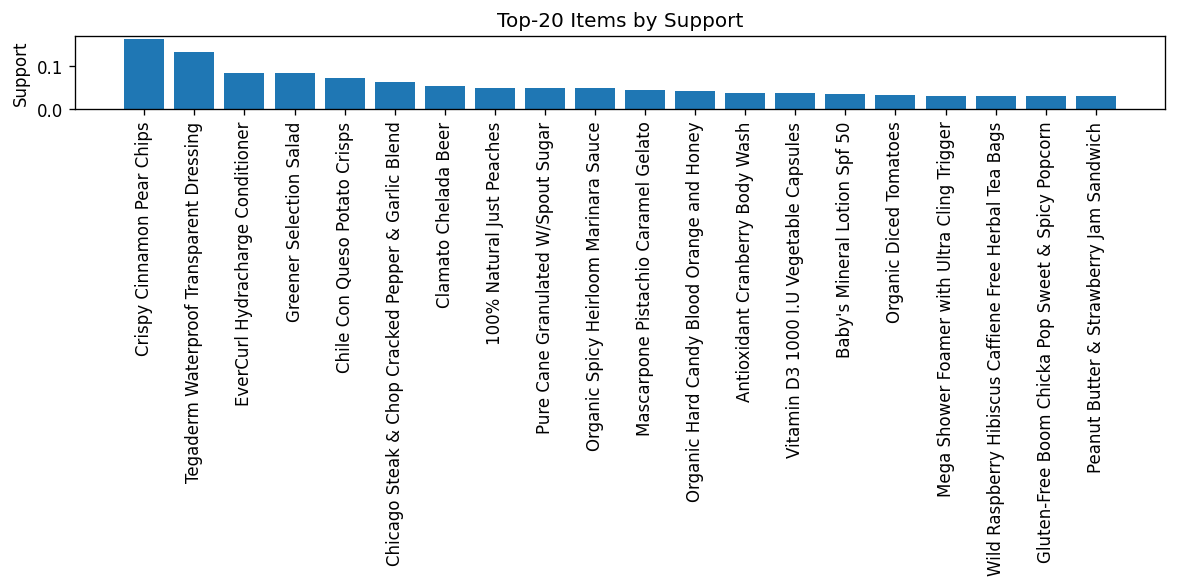

[FIG] saved fig_item_support_top20.png


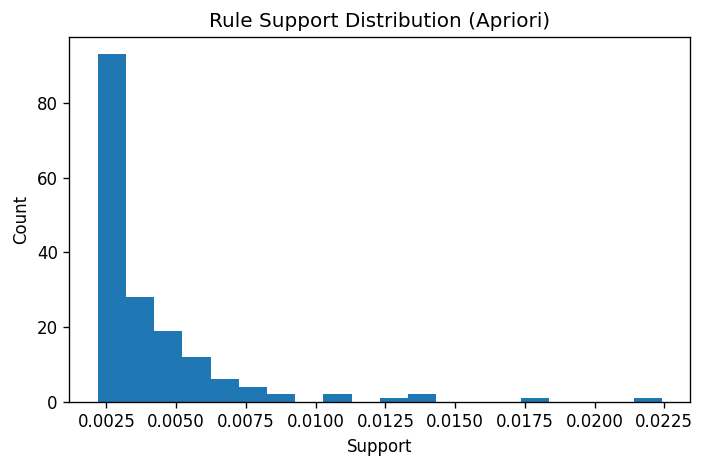

[FIG] saved fig_rule_support_hist_apriori.png


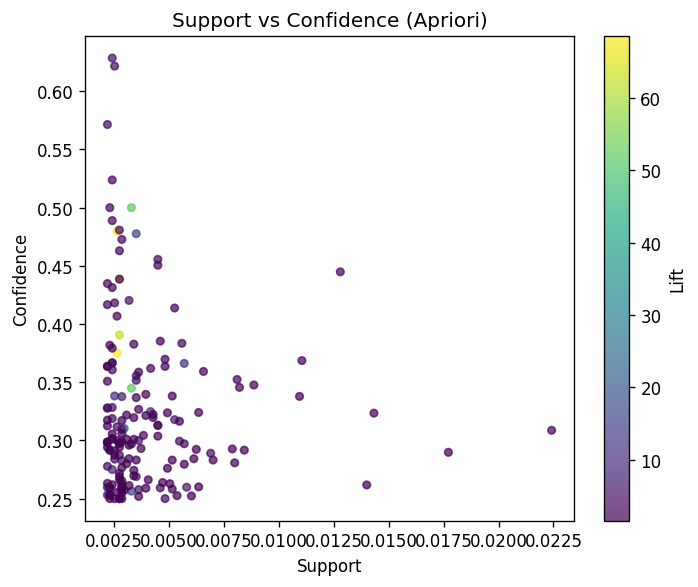

[FIG] saved fig_rule_support_confidence_scatter_apriori.png


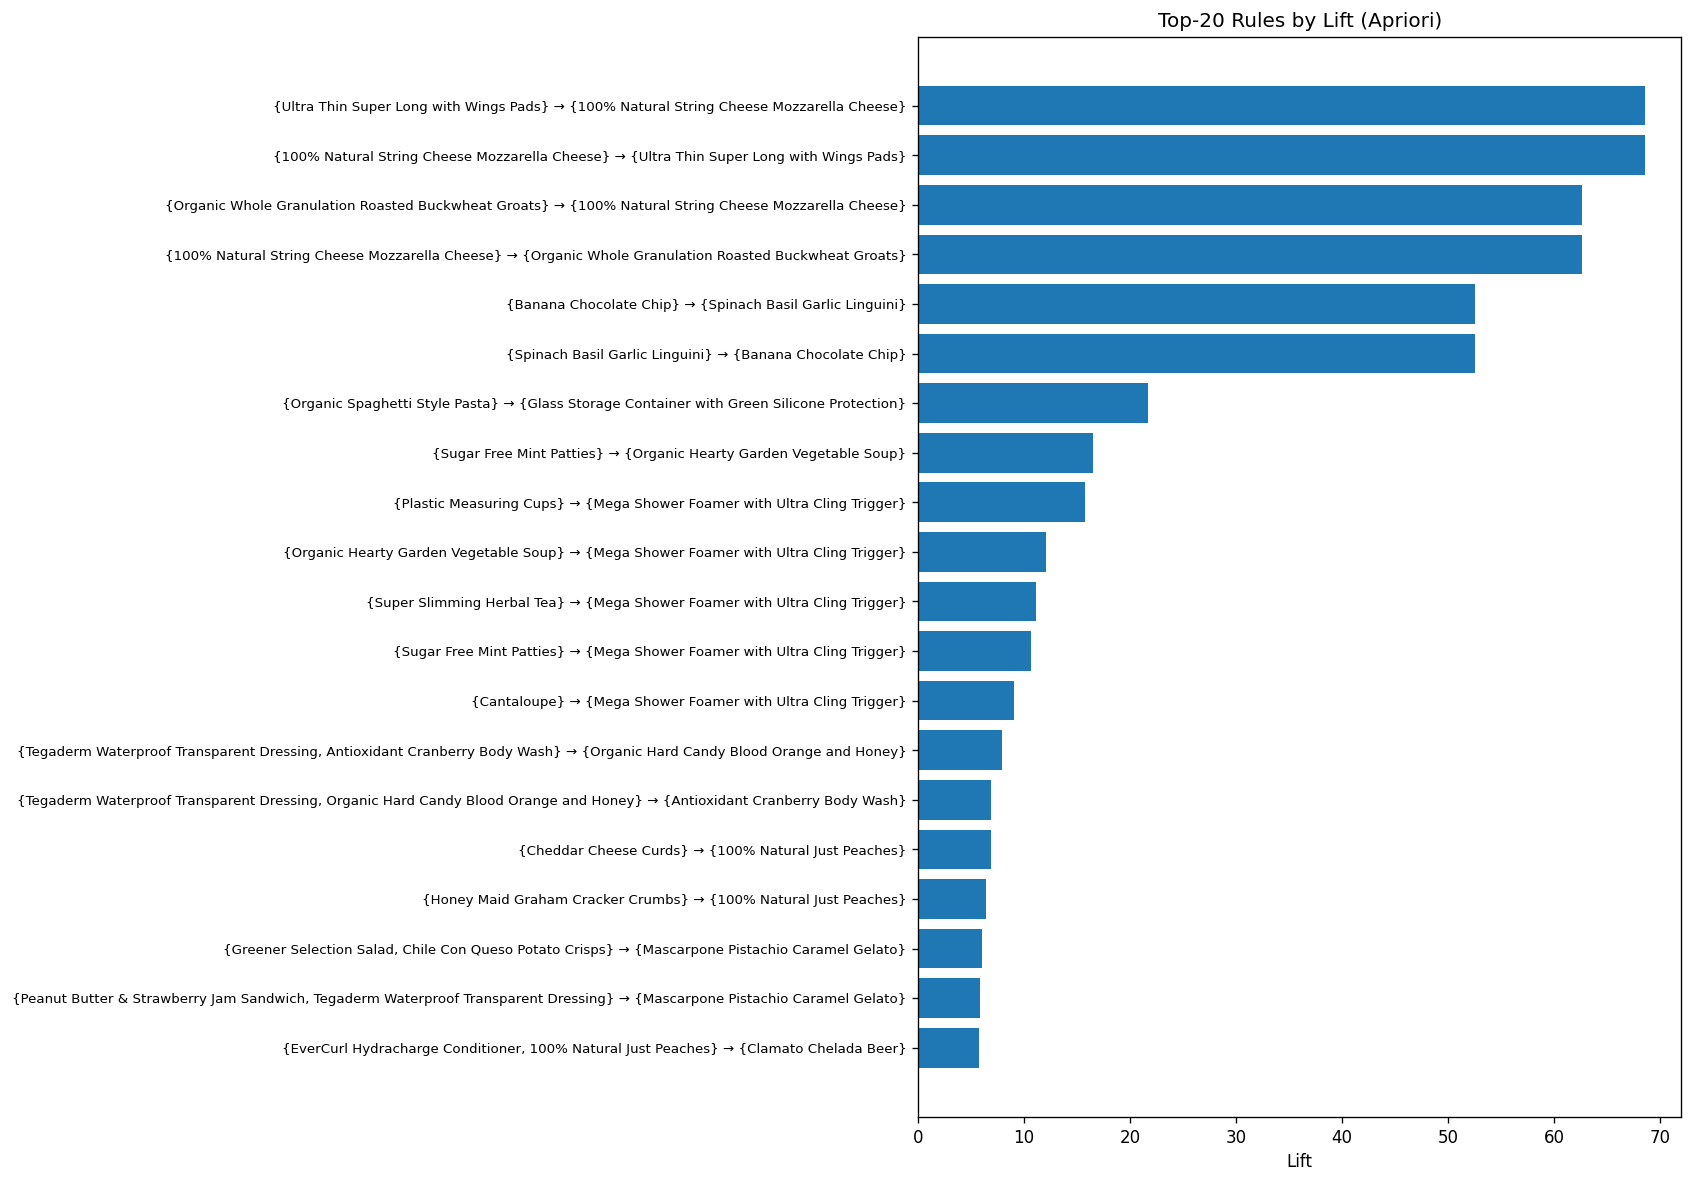

[FIG] saved fig_rule_top20_lift_apriori.png


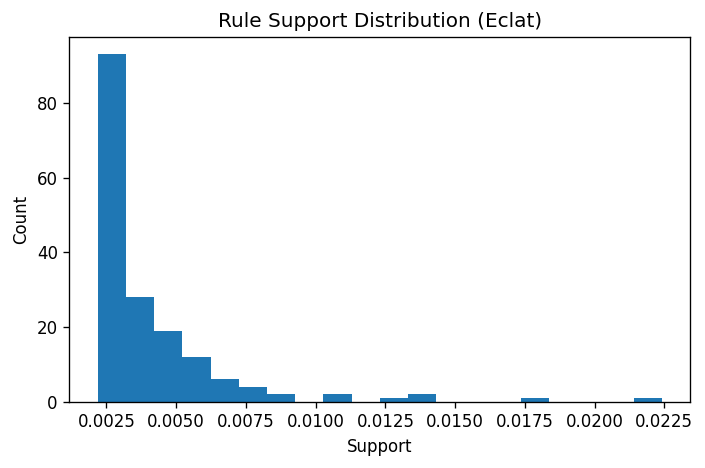

[FIG] saved fig_rule_support_hist_eclat.png


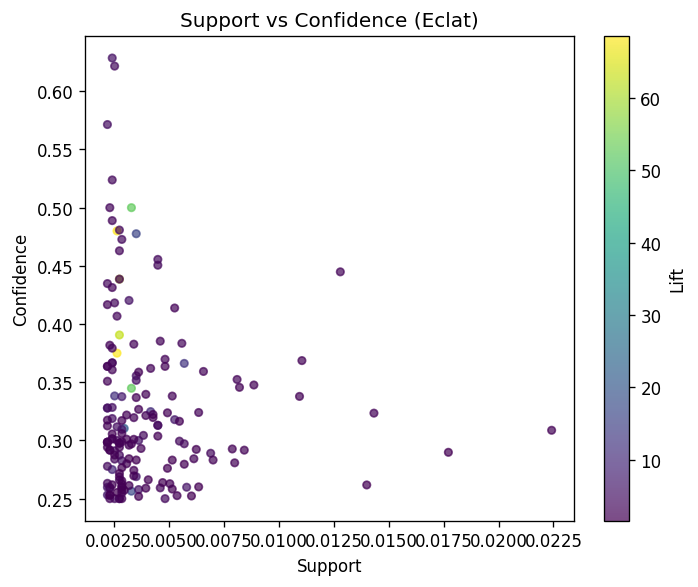

[FIG] saved fig_rule_support_confidence_scatter_eclat.png


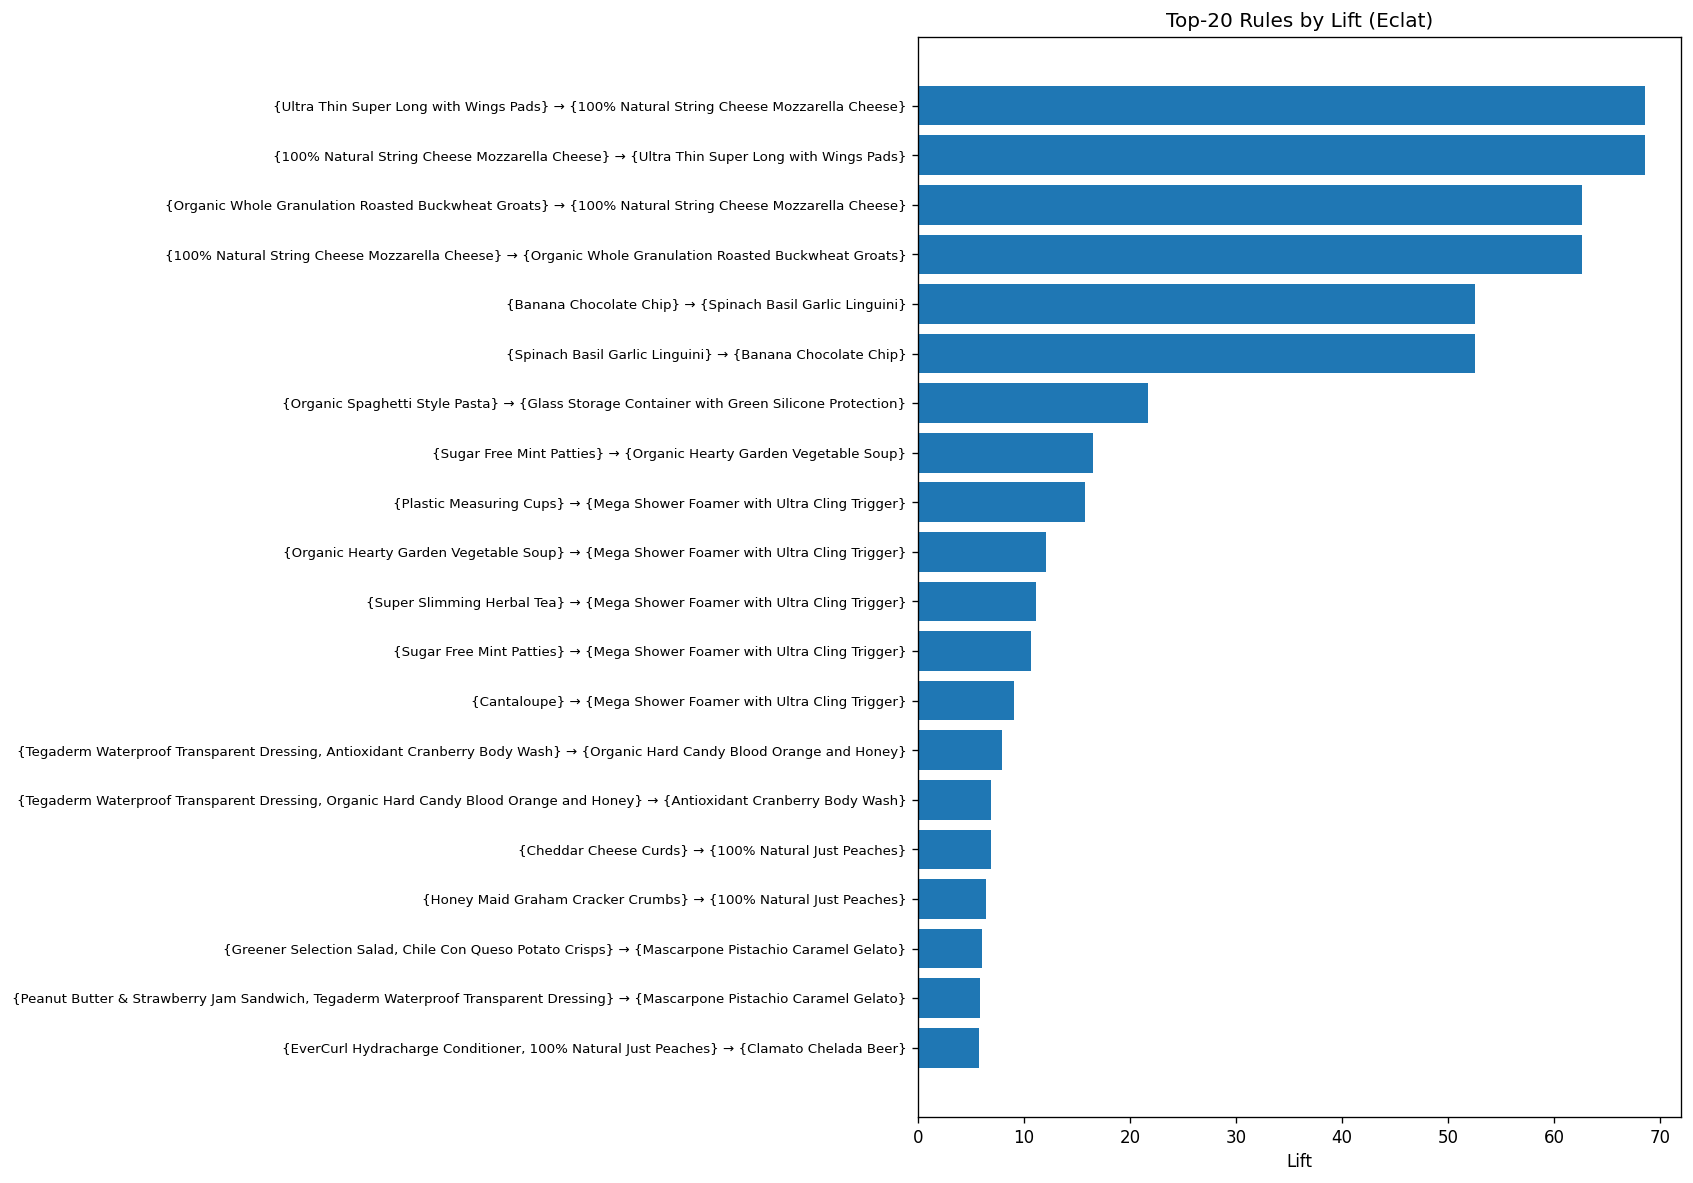

[FIG] saved fig_rule_top20_lift_eclat.png


In [13]:
# Top-20 items
plot_top_item_support(freq_apriori_df, top_k=20, filename=FIG_ITEM_SUPPORT_TOP20)
# Apriori rule plots
plot_rule_support_hist(rules_apriori, "Apriori", FIG_RULE_SUPPORT_HIST_AP)
plot_rule_support_confidence_scatter(rules_apriori, "Apriori", FIG_RULE_SCATTER_AP)
plot_top_lift_rules(rules_apriori, "Apriori", FIG_RULE_LIFT_TOP_AP, top_k=20)
# Eclat rule plots
plot_rule_support_hist(rules_eclat, "Eclat", FIG_RULE_SUPPORT_HIST_EC)
plot_rule_support_confidence_scatter(rules_eclat, "Eclat", FIG_RULE_SCATTER_EC)
plot_top_lift_rules(rules_eclat, "Eclat", FIG_RULE_LIFT_TOP_EC, top_k=20)
# top-10 rules for PPT
if not rules_apriori.empty:
    top_ppt = select_top_lift_rules_for_plot(rules_apriori, top_k=10)
    top_ppt.to_csv(OUT_TOP_RULES_PPT, index=False)
    top_ppt.head(10)
else:
    print("no rules for PPT file")

[SENS] Eclat minsup sensitivity
[SENS][Eclat] minsup_abs=20 ...
[ECLAT] minsup_abs=20, max_len=3
[ECLAT] |L1| = 891
[ECLAT] total frequent itemsets = 1602
   itemsets=1602, rules=171, time=0.25s
[SENS][Eclat] minsup_abs=30 ...
[ECLAT] minsup_abs=30, max_len=3
[ECLAT] |L1| = 521
[ECLAT] total frequent itemsets = 833
   itemsets=833, rules=78, time=0.10s
[SENS][Eclat] minsup_abs=40 ...
[ECLAT] minsup_abs=40, max_len=3
[ECLAT] |L1| = 342
[ECLAT] total frequent itemsets = 498
   itemsets=498, rules=48, time=0.06s
[SENS] saved Eclat minsup sensitivity to eclat_minsup_sensitivity.csv
[SENS] Apriori minsup sensitivity (may be slow)
[SENS][Apriori] minsup_abs=20 ...
[APRIORI] minsup_abs=20, max_len=3
[APRIORI] |L1| = 891
[APRIORI] |L2| = 675
[APRIORI] |L3| = 36
[APRIORI] total frequent itemsets = 1602
   itemsets=1602, rules=171, time=171.88s
[SENS][Apriori] minsup_abs=30 ...
[APRIORI] minsup_abs=30, max_len=3
[APRIORI] |L1| = 521
[APRIORI] |L2| = 304
[APRIORI] |L3| = 8
[APRIORI] total frequen

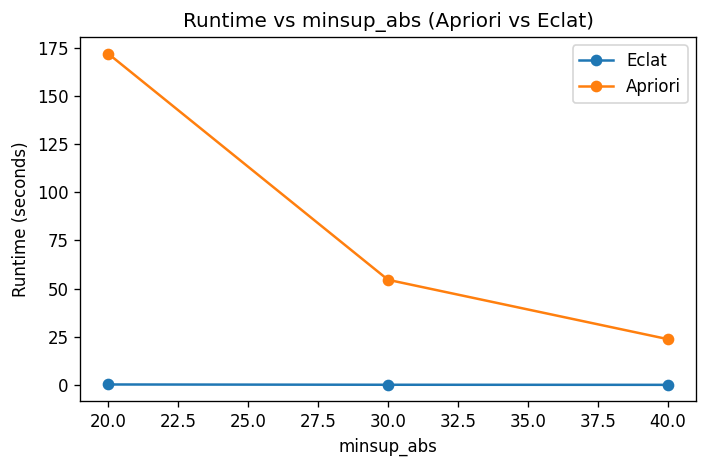

[FIG] saved fig_runtime_vs_minsup_apriori_eclat.png


In [14]:
print("[SENS] Eclat minsup sensitivity")
eclat_sens_df = run_eclat_minsup_sensitivity(transactions, N)
eclat_sens_df
apriori_sens_df = None
if APRIORI_SENS_ENABLED:
    print("[SENS] Apriori minsup sensitivity (may be slow)")
    apriori_sens_df = run_apriori_minsup_sensitivity(transactions, N)
apriori_sens_df
plot_runtime_vs_minsup_both(eclat_sens_df, apriori_sens_df,
                            filename=FIG_RUNTIME_MINSUP_BOTH)

In [15]:
fig_files = [
    FIG_ITEM_SUPPORT_TOP20,
    FIG_RULE_SUPPORT_HIST_AP,
    FIG_RULE_SCATTER_AP,
    FIG_RULE_LIFT_TOP_AP,
    FIG_RULE_SUPPORT_HIST_EC,
    FIG_RULE_SCATTER_EC,
    FIG_RULE_LIFT_TOP_EC,
    FIG_RUNTIME_MINSUP_BOTH,
]
save_all_figures_to_pdf(fig_files, out_pdf=OUT_PDF)
print("Done. Key outputs saved as CSV, PNG, and PDF in the current folder.")

[VIZ] saved all figures into association_rules_plots.pdf
Done. Key outputs saved as CSV, PNG, and PDF in the current folder.
